In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


target_shape = (200, 200)

In [59]:
anchor_images_path = "train/left"
positive_images_path = "train/right"

In [60]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [61]:
df=pd.read_csv("train.csv")

In [62]:
train_left = []
train_right = []
for i in range(2000):
    train_left.append("train/left/" + df.left[i] + '.jpg')
    train_right.append("train/right/" + df.right[i] +'.jpg')


In [63]:
print(train_right[:20])

['train/right/osr.jpg', 'train/right/mqw.jpg', 'train/right/cdx.jpg', 'train/right/uzp.jpg', 'train/right/bbd.jpg', 'train/right/ais.jpg', 'train/right/lyf.jpg', 'train/right/hve.jpg', 'train/right/vrz.jpg', 'train/right/yxn.jpg', 'train/right/jdy.jpg', 'train/right/lts.jpg', 'train/right/iml.jpg', 'train/right/htp.jpg', 'train/right/pxl.jpg', 'train/right/uyr.jpg', 'train/right/mrv.jpg', 'train/right/zcc.jpg', 'train/right/fpd.jpg', 'train/right/mgp.jpg']


In [64]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = train_left

positive_images = train_right

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

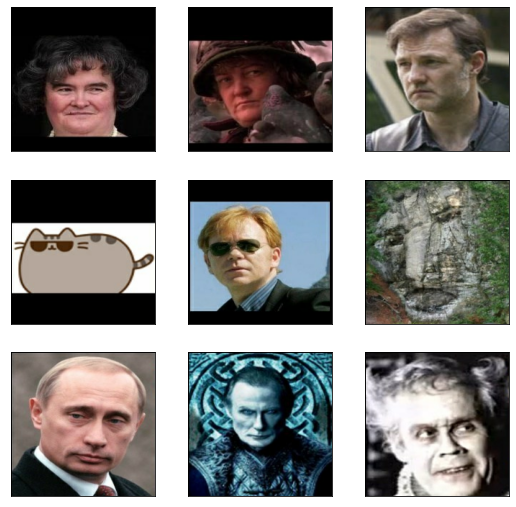

In [71]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [72]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [73]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [74]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [76]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), weighted_metrics=["loss"])
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
50/50 [==============================] - 212s 4s/step - loss: 0.4105 - val_loss: 0.3820
Epoch 2/10
50/50 [==============================] - 201s 4s/step - loss: 0.3775 - val_loss: 0.3494
Epoch 3/10
50/50 [==============================] - 202s 4s/step - loss: 0.3457 - val_loss: 0.3307
Epoch 4/10
50/50 [==============================] - 202s 4s/step - loss: 0.3380 - val_loss: 0.3270
Epoch 5/10
50/50 [==============================] - 204s 4s/step - loss: 0.3129 - val_loss: 0.2791
Epoch 6/10
50/50 [==============================] - 201s 4s/step - loss: 0.2900 - val_loss: 0.2535
Epoch 7/10
50/50 [==============================] - 202s 4s/step - loss: 0.3066 - val_loss: 0.2387
Epoch 8/10
50/50 [==============================] - 202s 4s/step - loss: 0.2615 - val_loss: 0.2589
Epoch 9/10
50/50 [==============================] - 204s 4s/step - loss: 0.2683 - val_loss: 0.2365
Epoch 10/10
50/50 [==============================] - 201s 4s/step - loss: 0.2547 - val_loss: 0.2359


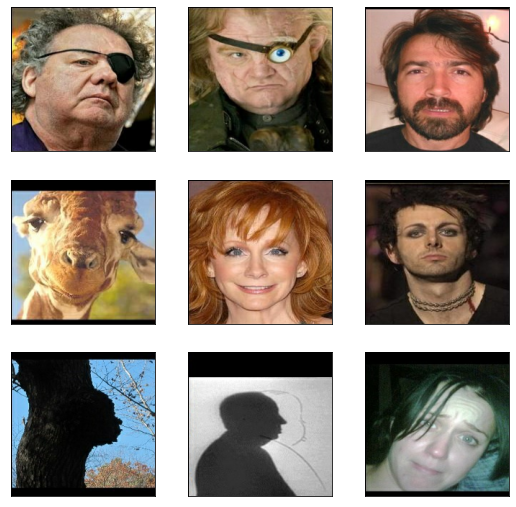

In [77]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [136]:
def predict(anchor_image_path, test_image_path1, test_image_path2):
    # 1. 预处理图像
    anchor_image = preprocess_image(anchor_image_path)
    test_image1 = preprocess_image(test_image_path1)
    test_image2 = preprocess_image(test_image_path2)
    
    # 扩展维度以匹配模型的输入维度
    anchor_image = tf.expand_dims(anchor_image, axis=0)
    test_image1 = tf.expand_dims(test_image1, axis=0)
    test_image2 = tf.expand_dims(test_image2, axis=0)
    
    # 2. 使用模型进行预测
    distances = siamese_network.predict([anchor_image, test_image1, test_image2], verbose=0)
    
    # 3. 使用Sigmoid函数归一化距离
    normalized_distance1 = tf.sigmoid(distances[0])
    normalized_distance2 = tf.sigmoid(distances[1])
    
    # 4. 计算相似度
    similarity_score1 = 1 - normalized_distance1[0]
    similarity_score2 = 1 - normalized_distance2[0]
    
    return similarity_score1, similarity_score2


In [137]:
test_pair=pd.read_csv("test_candidates.csv")
test_data = []
for i in range(len(test_pair)):
    left_path = test_pair.left[i] + '.jpg'
    for j in range(0,len((test_pair.loc[i,"c0":"c19"])),2):
        temp = []
        right1_path = test_pair.loc[i,"c0":"c19"][j] + '.jpg'
        right2_path = test_pair.loc[i,"c0":"c19"][j + 1] + '.jpg'
        temp.append(left_path)
        temp.append(right1_path)
        temp.append(right2_path)
        test_data.append(temp)

In [138]:
test_data[:20]

[['abm.jpg', 'kyr.jpg', 'qqo.jpg'],
 ['abm.jpg', 'xpv.jpg', 'tnd.jpg'],
 ['abm.jpg', 'xal.jpg', 'pvr.jpg'],
 ['abm.jpg', 'nsb.jpg', 'yzv.jpg'],
 ['abm.jpg', 'ahb.jpg', 'mlm.jpg'],
 ['abm.jpg', 'drb.jpg', 'vqu.jpg'],
 ['abm.jpg', 'vzr.jpg', 'kxe.jpg'],
 ['abm.jpg', 'mdq.jpg', 'oai.jpg'],
 ['abm.jpg', 'nmm.jpg', 'yzu.jpg'],
 ['abm.jpg', 'ihk.jpg', 'zwv.jpg'],
 ['aci.jpg', 'jzn.jpg', 'hxw.jpg'],
 ['aci.jpg', 'iaj.jpg', 'edq.jpg'],
 ['aci.jpg', 'huu.jpg', 'huk.jpg'],
 ['aci.jpg', 'owo.jpg', 'ntd.jpg'],
 ['aci.jpg', 'uhk.jpg', 'ojv.jpg'],
 ['aci.jpg', 'mhg.jpg', 'exb.jpg'],
 ['aci.jpg', 'pny.jpg', 'kbo.jpg'],
 ['aci.jpg', 'tdb.jpg', 'sok.jpg'],
 ['aci.jpg', 'zsq.jpg', 'yfg.jpg'],
 ['aci.jpg', 'iqx.jpg', 'jnj.jpg']]

In [143]:
# 获取两个图像的嵌入向量
similarity = []
count = 0
for test_left, test_right1, test_right2 in test_data:
    count += 1
    # print(test_left + " ---- " + test_right)
    anchor_image_path = "test/left/" + test_left
    test_image_path1 = "test/right/" + test_right1
    test_image_path2 = "test/right/" + test_right2

# 计算两个嵌入向量之间的相似度
    distance1, distance2 = predict(anchor_image_path, test_image_path1, test_image_path2)
    similarity.append(distance1.numpy())
    similarity.append(distance2.numpy())
    if count % 1000 == 0:
        print(count)


KeyboardInterrupt: 

In [144]:
similarity[:20]

[0.41977835,
 0.27311242,
 0.27206033,
 0.068100154,
 0.15328175,
 0.26276177,
 0.43943274,
 0.32311398,
 0.242464,
 0.40101582,
 0.067117035,
 0.3280341,
 0.08600491,
 0.354042,
 0.34070057,
 0.43657583,
 0.45483828,
 0.20393854,
 0.4718327,
 0.3134889]

In [133]:
import csv


# 读取CSV文件
with open('submission_resNet.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]

# 更新CSV文件的值
for i in range(1, len(rows)):  # 从第二行开始，因为第一行是标题行
    for j in range(1, 21):  # 对于c0到c19
        rows[i][j] = similarity[(i-1)*20 + (j-1)]

# 将更新后的值写回CSV文件
with open('submission_resNet.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)